In [1]:
import numpy as np
import pandas as pd
from biom import Table
from biom import load_table

from birdman_jr.data_driven import (dirichlet_multinomial, negative_binomial,
                                    poisson_lognormal, simulate)
from birdman_jr.generators import blocks, gradient

import qiime2 as q2
from qiime2.plugins.gemelli.actions import rpca
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.composition import clr, closure

from gneiss.util import match
from gneiss.cluster._pba import correlation_linkage, gradient_linkage
from gneiss.sort import gradient_sort, mean_niche_estimator
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
%matplotlib inline

# Gradient Example - 88 Soils

In [6]:

in_biom='data/88soils/table.biom'
in_meta='data/88soils/metadata.txt'
table = load_table(in_biom)
table = table.to_dataframe().T
table = table[table.T.sum() > 500].fillna(0)
table = table.T[table.sum() > 10].T
meta = pd.read_table(in_meta,index_col=0)
table,meta = match(table,meta)

# order grad
table_grad = table.copy()
table_grad.sort_index()
c = pd.Series(meta['ph'])
table, c = match(table_grad, c)

#order gradient 
t = gradient_linkage(table_grad+1, c, method='average')
mean_g = mean_niche_estimator(table_grad, c)
mean_g = pd.Series(mean_g, index=table_grad.columns)
mean_g = mean_g.sort_values()

# plot the gradient
table_grad = table_grad.reindex(index=meta.sort_values('ph').index,
                                columns=mean_g.index)


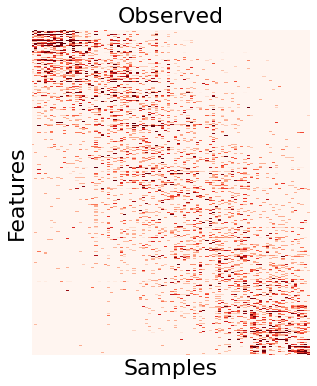

In [7]:

fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(clr(table_grad.T + 1), cmap='Reds', aspect='auto', interpolation='nearest', vmin=1e-12, vmax=2)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Observed',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()


In [8]:
# generate simulation
n_samples, n_features = 20, 500 
g = np.linspace(0, 9, n_samples)
mu = np.linspace(0, 9, n_features)
sigma = [2.0] * n_features
example_sim = gradient(g, mu, sigma)
example_sim.shape


(20, 500)

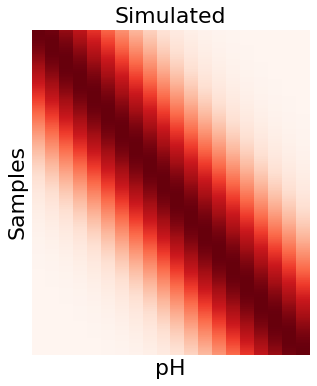

In [9]:

fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(example_sim.T, cmap='Reds', aspect='auto', interpolation='nearest')


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Simulated',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Samples',
                  color='black',
                  fontsize=22)
ax.set_xlabel('pH',
                  color='black',
                  fontsize=22)
plt.show()


# Block Example - Keyboard

In [10]:
in_biom='/Users/cmartino/Dropbox/bin/phylo-rapca/keyboard/table.biom'
in_meta='/Users/cmartino/Dropbox/bin/phylo-rapca/keyboard/metadata.txt'

table = load_table(in_biom)
table = table.to_dataframe().T
meta = pd.read_table(in_meta,index_col=0)
meta = meta[meta['host_subject_id'].isin(['M9','M2','M3'])]
meta['encoded_host_id']=LabelEncoder().fit_transform(meta.host_subject_id.values)
table,meta = match(table,meta)
table = table.T[table.sum() > 10].T
table = table[table.T.sum() > 100]
table, meta = match(table, meta)


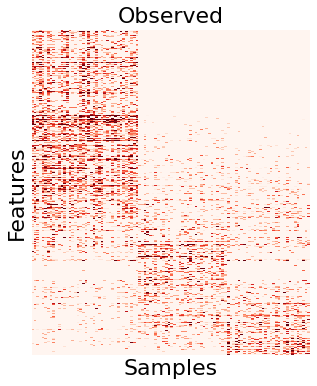

In [11]:
table_block = table.copy()
table_block.sort_index()
c = pd.Series(meta['encoded_host_id'])
table, c = match(table_block, c)
t = gradient_linkage(table_block+1, c, method='average')
mean_g = mean_niche_estimator(table_block, c)
mean_g = pd.Series(mean_g, index=table_block.columns)
mean_g = mean_g.sort_values()
# plot the gradient
table_block = table_block.reindex(index=meta.sort_values('encoded_host_id').index,columns=mean_g.index)

fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(clr(table_block.T + 1), cmap='Reds', aspect='auto', interpolation='nearest', vmin=1e-12, vmax=2)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Observed',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()


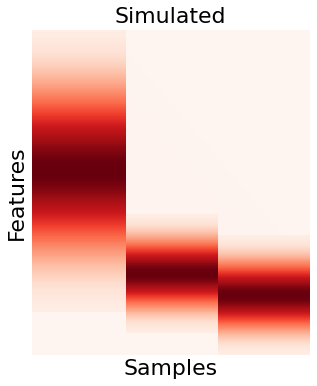

In [12]:

block_sim = blocks(1000, 100, 3, sigma=2, overlap=200, minval=0, maxval=100)
block_sim = block_sim[::-1, ::-1]


fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(block_sim.T, cmap='Reds', aspect='auto', interpolation='nearest')


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Simulated',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()


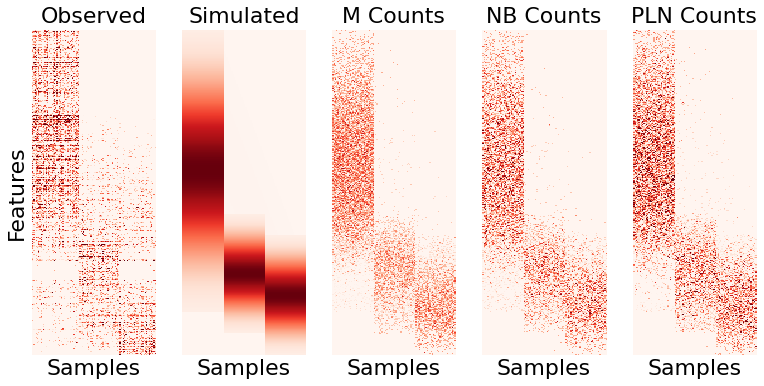

In [13]:

fig, axn = plt.subplots(1,5, figsize=(13, 6), sharey=False)
axn = axn.flatten()

models_run = {'M':dirichlet_multinomial, 
              'NB':negative_binomial,
              'PLN':poisson_lognormal}

#obs
ax = axn[0]
ax.imshow(clr(table_block.T + 1), cmap='Reds', aspect='auto', interpolation='nearest', vmin=1e-12, vmax=2)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Observed',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)

# props
ax = axn[1]
ax.imshow(block_sim.T, cmap='Reds', aspect='auto', interpolation='nearest')


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Simulated',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)


for ax, (model_, model_sim) in zip(axn[2:], models_run.items()):
    
    count_table_tmp = model_sim(block_sim, block_sim.sum(1).reshape(-1, 1) / 10)[0]
    
    ax.imshow(clr(count_table_tmp.T + 1), cmap='Reds', aspect='auto',
              interpolation='nearest', vmin=1e-12, vmax=2)


    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title('%s Counts' % (model_),
                      color='black',
                      #weight='bold',
                      fontsize=22)
    #ax.set_ylabel('Features',
    #                  color='black',
                      #weight='bold',
    #                  fontsize=22)
    ax.set_xlabel('Samples',
                      color='black',
                      #weight='bold',
                      fontsize=22)
plt.show()

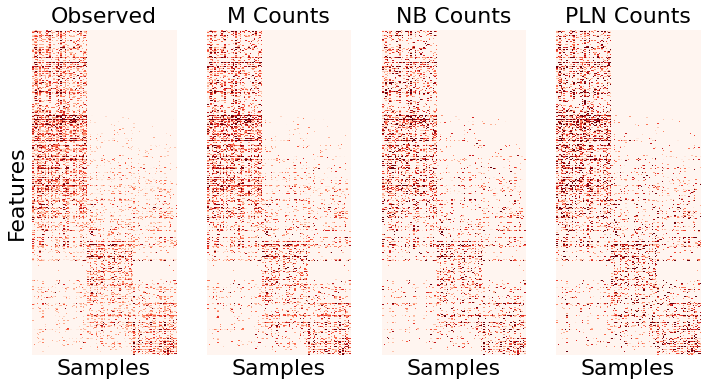

In [14]:

fig, axn = plt.subplots(1, 4, figsize=(12, 6), sharey=False)
axn = axn.flatten()

models_run = {'m':dirichlet_multinomial, 
              'nb':negative_binomial,
              'pln':poisson_lognormal}

#obs
ax = axn[0]
ax.imshow(clr(table_block.T + 1), cmap='Reds', aspect='auto', interpolation='nearest', vmin=1e-12, vmax=2)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Observed',
                  color='black',
                  #weight='bold',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  #weight='bold',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  #weight='bold',
                  fontsize=22)


for ax, (model_, model_sim) in zip(axn[1:], models_run.items()):
    
    bt_test = Table(table_block.values.T, table_block.T.index, table_block.T.columns)
    bt_res = simulate(bt_test, bt_test.sum('sample').reshape(bt_test.shape[1], -1),
                      distribution=model_)

    count_table_tmp = bt_res.to_dataframe()    
    
    ax.imshow(clr(count_table_tmp + 1), cmap='Reds', aspect='auto',
              interpolation='nearest', vmin=1e-12, vmax=2)


    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title('%s Counts' % (model_.upper()),
                      color='black',
                      #weight='bold',
                      fontsize=22)
    #ax.set_ylabel('Features',
    #                  color='black',
                      #weight='bold',
    #                  fontsize=22)
    ax.set_xlabel('Samples',
                      color='black',
                      #weight='bold',
                      fontsize=22)
plt.show()

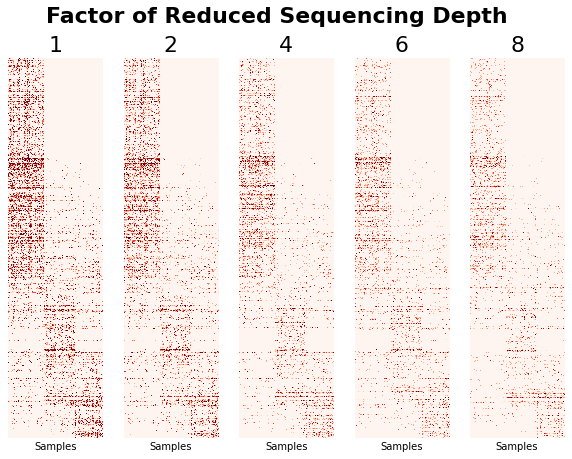

In [15]:
fig, axn = plt.subplots(1, len([1, 2, 4, 6, 8]), figsize=(10, 7), sharey=False)


bt_test = Table(table_block.values.T, table_block.T.index, table_block.T.columns)
q2bt_res = q2.Artifact.import_data('FeatureTable[Frequency]', bt_test)
dist_tmp = rpca(q2bt_res).distance_matrix.view(DistanceMatrix)

for n_factor, ax in zip([1, 2, 4, 6, 8], axn):

    bt_res = simulate(bt_test, bt_test.sum('sample').reshape(bt_test.shape[1], -1) // n_factor,
                      distribution='pln')
    q2bt_res = q2.Artifact.import_data('FeatureTable[Frequency]', bt_res)
    dist_tmp = rpca(q2bt_res).distance_matrix.view(DistanceMatrix)
    count_table_tmp = bt_res.to_dataframe()    
    
    ax.imshow(clr(count_table_tmp + 1), cmap='Reds', aspect='auto',
              interpolation='nearest', vmin=1e-12, vmax=2)


    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title('%i' % (n_factor),
                      color='black',
                      fontsize=22)
    ax.set_xlabel('Samples',
                      color='black',
                      fontsize=10)
    
plt.suptitle('Factor of Reduced Sequencing Depth',
                      color='black',
                      weight='bold',
                      fontsize=22)
    
plt.show()

In [16]:
f_stats = {}
for fold in range(10):
    for n_factor, ax in zip([1, 2, 4, 6, 8], axn):

        bt_res = simulate(bt_test, bt_test.sum('sample').reshape(bt_test.shape[1], -1) // n_factor,
                          distribution='pln')
        q2bt_res = q2.Artifact.import_data('FeatureTable[Frequency]', bt_res)
        dist_tmp = rpca(q2bt_res).distance_matrix.view(DistanceMatrix)
        f_stats[(fold, n_factor)] = [permanova(dist_tmp,
                                               meta.loc[dist_tmp.ids, 'host_subject_id'])['test statistic']]

f_stats_df = pd.DataFrame(f_stats).T.reset_index()
f_stats_df.columns = ['fold', 'Factor of Reduced Sequencing Depth', 'PERMANOVA F-stat.']
f_stats_df.head(3)


,fold,Factor of Reduced Sequencing Depth,PERMANOVA F-stat.
0,0,1,50.863294
1,0,2,40.162105
2,0,4,23.794484


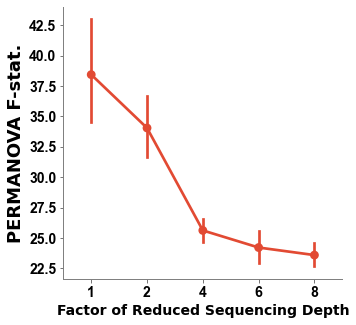

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.pointplot(x='Factor of Reduced Sequencing Depth', y='PERMANOVA F-stat.', data=f_stats_df, ax=ax)


ax.set_ylabel('PERMANOVA F-stat.',
              color='black',
              weight='bold',
              fontsize=18) 
ax.set_xlabel('Factor of Reduced Sequencing Depth',
              color='black',
              weight='bold',
              fontsize=14) 
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

plt.show()
